In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ollama
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.read_csv('data/prompts.csv')

,C,I,E,Q,T
0,You are an accomplished AI working as a human ...,Your task is to analyze some job description i...,This are the raw text from some job descriptio...,"This is the question: ""{Are the folowing job d...",Respond only with the exact binary label of ea...
1,You are an accomplished AI working as a lawyer...,Your task is to analyze some job descriptions ...,NaN,"This is the question: ""{Do the folowing job de...",NaN
2,You are an accomplished AI working as an Itali...,Your task is to analyze some job descriptions ...,NaN,"This is the question: ""{Classify the folowing ...",NaN
3,You are an accomplished AI working as a techni...,Your task is to analyze some job description i...,NaN,"This is the question: ""{Determine the binary l...",NaN
4,You are an accomplished AI working as a comput...,Your task is to analyze some job descriptions ...,NaN,"This is the question: ""{Which is the exact bin...",NaN
5,You are an accomplished AI working as a journa...,Your task is to revise some job descriptions i...,Here are the job descriptions: {job_desc},NaN,"You have to keep the structure {""job_decsripti..."
6,You are an accomplished AI working as an emplo...,NaN,NaN,NaN,NaN
7,You are an accomplished AI studying law in an ...,NaN,NaN,NaN,NaN
8,You are an accomplished AI living as a native ...,NaN,NaN,NaN,NaN
9,You are an accomplished AI working as a lawer ...,NaN,NaN,NaN,NaN


In [3]:
count_columns = lambda df, cols: df.groupby(cols).size().reset_index(name='counts').sort_values('counts', ascending=False)

filter_full_prompts = lambda df, ps: df[df['prompt_id'].isin(ps)]

def filter_zsl_prompts(df, prompt_ids_subpart):
    res_df = pd.DataFrame()
    for p in prompt_ids_subpart:
        _df = df[df['prompt_id'].str.contains(f"_{p}_") | df['prompt_id'].str.endswith(f"_{p}")]
        res_df = pd.concat([res_df, _df])
    return res_df

def filter_target(df, targets): 
    if type(targets) == str:
        targets = [targets,]
    res_df = pd.DataFrame()
    for t in targets:
        _df = df[df['target'].str.contains(t)]
        res_df = pd.concat([res_df, _df])
    return res_df

LABELS = ['maschile', 'femminile', 'neutro']

def preprocess_label_df(_df):
    df = _df.copy()
    def improve(_x):
        x = _x['prediction']
        x = str(x).replace('"','').replace('*','').lower()
        if "maschile/femminile" in x:
            return "neutro"
        if "femminile/maschile" in x:
            return "neutro" 
        if "femminile/neutro" in x:
            return "neutro"
        if "maschile/neutro" in x:
            return "neutro"
        if "entrambi" in x:
            return "neutro"
        if x not in LABELS:
            return "none"
        return x
    #f['prediction'] = df.apply(lambda x: improve(x), axis=1)
    
    # specific c0_i0_e0_t2, c0_i0_e1_t3
    def extrapolate(row):
        x = row['prediction'].lower().replace('"','')
        wrd = x
        for w in [
                'si riferisce al genere ',
                    'genere: ',
                    'classificazione: ',
                    'lassificato come ',
                    'lassificato come: ',
                    'riferisce a un genere ',
                    'riferisce a ',
                    'riferisce al ',
                    'è di genere ',
                    'con genere ',
                    'riferito al genere ',
                    'la risposta è: ',
                ]:
            if w in x:
                wrd = x.split(w)[1]#.split(' ')[0]
                break
            
        for w in [
            'genere ',
            'risposta: ',
        ]:
            if wrd.startswith(w):
                wrd = wrd.split(' ')[1]

        for w in [
            'maschile/femminile',
            'maschile e femminile',
            'femminile e maschile',
            'femminile e neutro',
            'maschile o femminile',
            'femminile o neutro',
            'maschile o neutro',
            'femminile/maschile',
            'femminile/neutro',
            'neutro/femminile',
            'entramb',
            'neutro/entrambi',
            'm/f',
            'misto',
            'il testo si riferisce sia ',
        ]:
            if wrd.startswith(w):
                return 'neutro'
            
        for l in LABELS:
            if wrd.startswith('**'+l):
                return l
            if wrd.startswith('il testo è '+l):
                return l
            if wrd.startswith(l):
                for e in ['\n','*','.',';',',',':',
                        ' poich',
                        f" ({row['target']})",
                        '/spiegazione',
                        ' in italiano',
                        ' (entrambi).',
                        ' (entrambi),',
                        ]:
                    if wrd.startswith(l+e):
                        return l
                try:
                    idx = wrd.index(')')
                    if len(wrd) == idx+1:
                        return l
                    if wrd[idx+1] == '\n':
                        return l
                    if wrd[idx+1] == '.':
                        return l
                except:
                    pass
        return wrd
    # df['prediction'] = df.apply(lambda x: extrapolate(x), axis=1)

    def choose(x):
        p = x['prompt_id']
        if '_t0' in p or '_t1' in p:
            return improve(x)
        return extrapolate(x)

    df['prediction'] = df.apply(lambda x: choose(x), axis=1)

    df = df[df['prediction'].isin(LABELS)]
    return df

def valuate_label_results(df):
    accuracy = accuracy_score(df['ground_truth'], df['prediction'])
    f1 = f1_score(df['ground_truth'], df['prediction'], average='weighted')
    precision = precision_score(df['ground_truth'], df['prediction'], average='weighted')
    recall = recall_score(df['ground_truth'], df['prediction'], average='weighted')
    return accuracy, f1, precision, recall

def valuation_table(df, target_filters, inclusive=False):
    df_count = len(df)
    df = preprocess_label_df(df)
    df_count_after = len(df)

    if inclusive:
        df['ground_truth'] = df['ground_truth'].apply(lambda x: "inclusive" if x == "neutro" else "non inclusive")
        df['prediction'] = df['prediction'].apply(lambda x: "inclusive" if x == "neutro" else "non inclusive")

    res = pd.DataFrame({'target_filter':[], 'samples':[],'accuracy': [], 'f1': [], 'precision': [], 'recall': []})
    res.loc[len(res)] = [None,df_count_after/df_count] + list(valuate_label_results(df))
    for t in target_filters:
        _df = filter_target(df, t)
        res.loc[len(res)] = [t,len(_df)/df_count] + list(valuate_label_results(_df))
    return res

def analyze_label_results(df):

    sns.countplot(data=df, x='ground_truth')
    plt.show()

    print('Dataframe count:', len(df))
    df = preprocess_label_df(df)
    print('Dataframe count after preprocess:', len(df))

    sns.countplot(data=df, x='prediction')
    plt.show()

    df_pivot = df.pivot_table(index='ground_truth', columns='prediction', values='prompt_id', aggfunc='count', fill_value=0)
    sns.heatmap(df_pivot, annot=True, fmt='d')
    plt.show()

    cm = confusion_matrix(df['ground_truth'], df['prediction'], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    disp.plot()
    plt.show()

    accuracy, f1, precision, recall = valuate_label_results(df)

    plt.table(cellText=[[accuracy, f1, precision, recall]], colLabels=['Accuracy', 'F1', 'Precision', 'Recall'], cellLoc='center', loc='bottom')
    plt.axis('off')
    plt.show()
    
    return count_columns(df, ['prediction'])

neutrals = ['giornaista',
            'autista',
            'dentista',
            'ginnasta',
            'consulente',
            'estetista',
            'farmacista',
            'contabile',
            'nutrizionista',
            'giardiniere',
            'insegnante',
            'igienista dentale']

df = pd.read_csv('results/llama3_synt.csv')

_df = filter_full_prompts(df,['c0_e0_i1_q0'])
# indexes = _df[_df['prediction'].str.contains('enere: ')].index
# _df = preprocess_label_df(_df)
# for ln in _df.iloc[:50]['prediction']:
#     print(ln)
# _df['prediction'].unique()
# count_columns(_df, 'prediction')
valuation_table(_df, [])

,target_filter,samples,accuracy,f1,precision,recall
0,NaN,0.888889,0.710478,0.713227,0.716899,0.710478


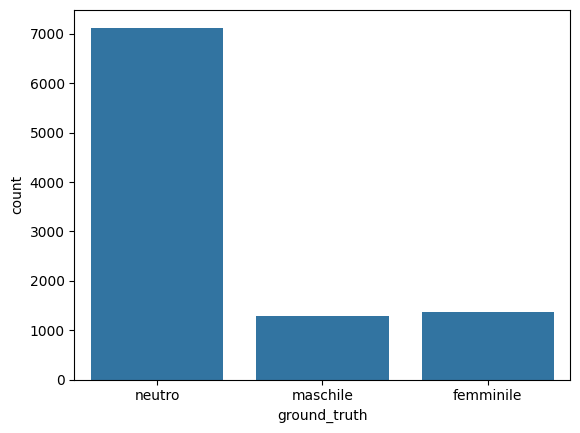

Dataframe count: 9792
Dataframe count after preprocess: 9768


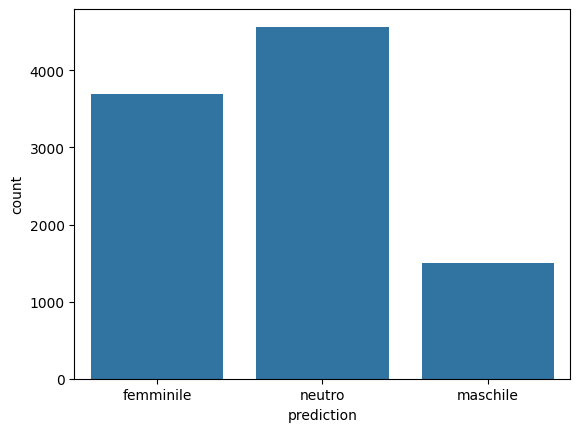

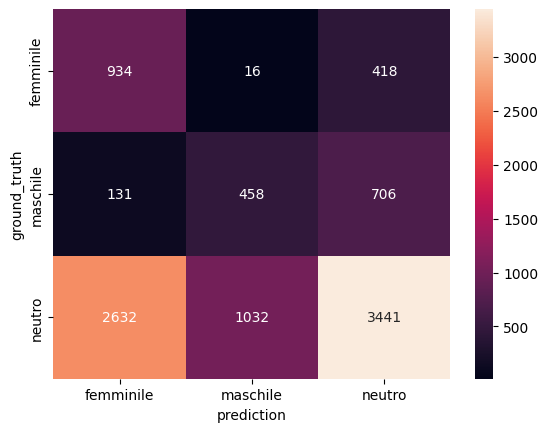

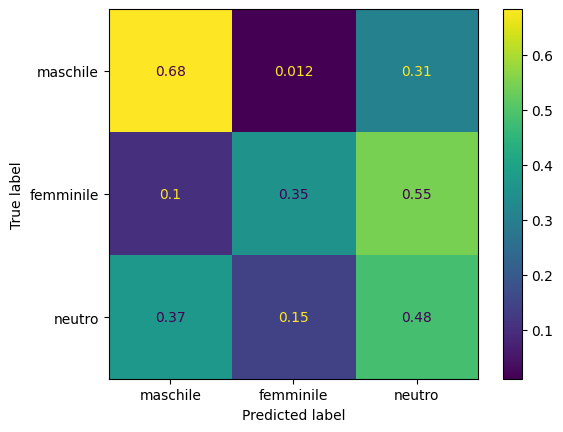

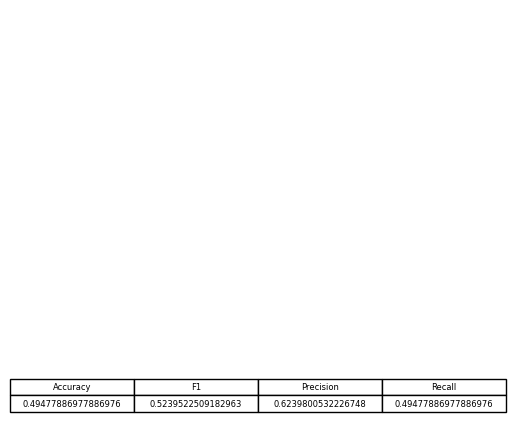

Analizing \*
Analizing /
Analizing Ã
Analizing  o 
Analizing ['giornaista', 'autista', 'dentista', 'ginnasta', 'consulente', 'estetista', 'farmacista', 'contabile', 'nutrizionista', 'giardiniere', 'insegnante', 'igienista dentale']


In [4]:
df_ttl = filter_zsl_prompts(df, ['t0'])
count_columns(df_ttl, 'prediction')
#analyze_label_results(df_ttl)
#valuation_table(df_ttl, ['\*','/','Ã',' o ',neutrals], False)

analyze_label_results(df_ttl)
for t in ['\*','/','Ã',' o ',neutrals]:
       print('Analizing', t)
       #analyze_label_results(filter_target(df_ttl, t))

In [8]:
res = None
for p in df['prompt_id'].unique():
    # if 't0' not in p and 't1' not in p and 't2' not in p:
    # if p != 'c0_i0_e1_t3':
    #     continue
    df_ttl = filter_full_prompts(df, [p])
    # _res = valuation_table(df_ttl, ['\*','/','Ã',' o ',neutrals], False)
    _res = valuation_table(df_ttl, [], False)
    _res['prompt_id'] = p
    if res is None:
        res = _res
    else:
        res = pd.concat([res, _res])
res = res.sort_values('f1', ascending=False).head(100)
res

,target_filter,samples,accuracy,f1,precision,recall,prompt_id
0,NaN,0.888889,0.710478,0.713227,0.716899,0.710478,c0_e0_i1_q0
0,NaN,0.976307,0.703766,0.712928,0.728694,0.703766,c0_i1_e0_t3
0,NaN,0.837418,0.667317,0.671255,0.676037,0.667317,c0_e1_i1_q0
0,NaN,0.998366,0.675123,0.649026,0.634606,0.675123,c0_i1_e0_q0_t0
0,NaN,0.959967,0.616170,0.638073,0.701601,0.616170,c0_i1_e1_t3
0,NaN,0.869281,0.607143,0.628492,0.727925,0.607143,c0_i1_e0_q0
0,NaN,0.810458,0.606855,0.625179,0.672580,0.606855,c0_e0_i0_q0
0,NaN,0.996732,0.610656,0.624390,0.658614,0.610656,c0_i1_e0_t0
0,NaN,0.996732,0.585246,0.599149,0.627124,0.585246,c0_i1_e1_q0_t0
0,NaN,0.988562,0.558678,0.584490,0.707489,0.558678,c0_i0_e0_q0_t3


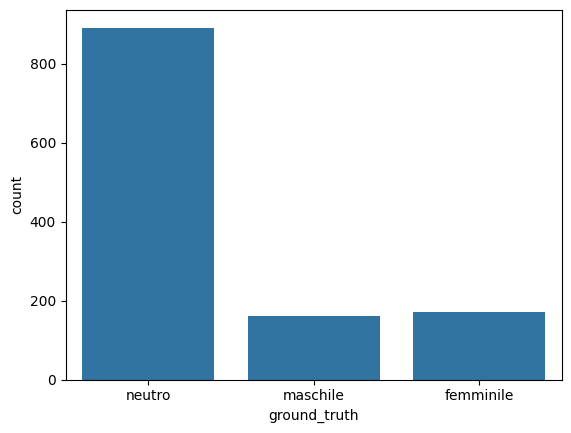

Dataframe count: 1224
Dataframe count after preprocess: 1088


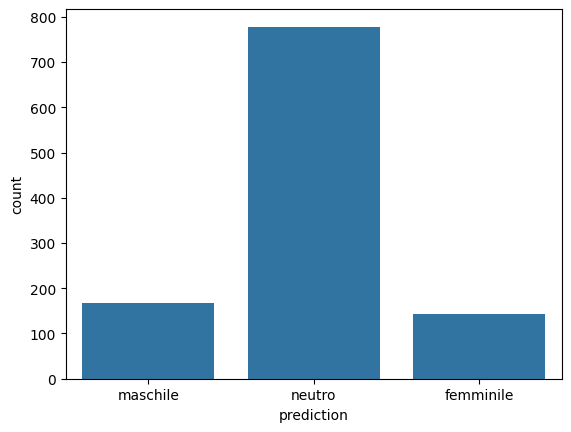

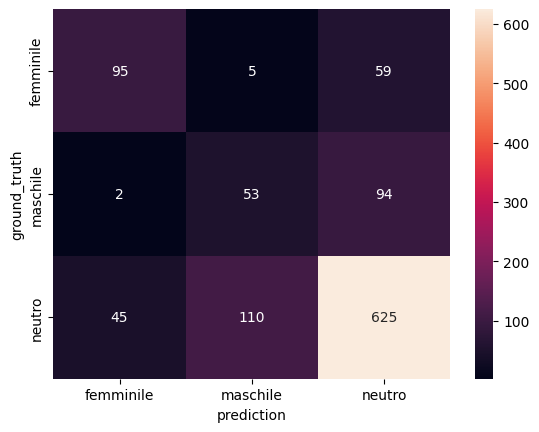

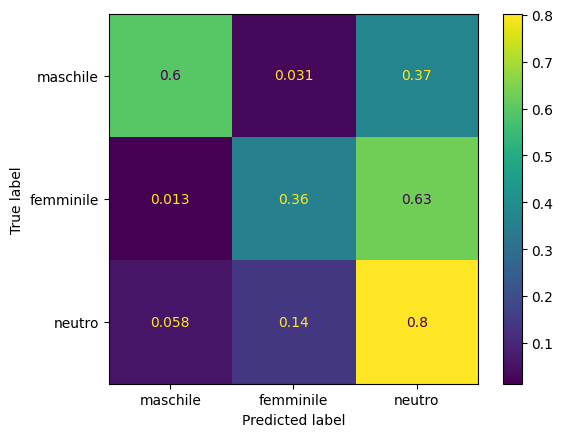

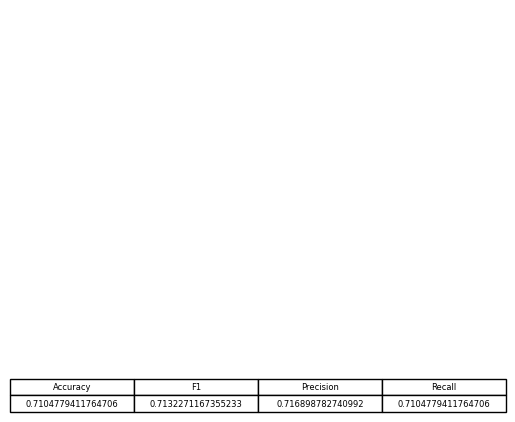

,prediction,counts
2,neutro,778
1,maschile,168
0,femminile,142


In [6]:
analyze_label_results(filter_full_prompts(df,['c0_e0_i1_q0']))


In [15]:
import generate
import random

for p in res['prompt_id'].unique()[:1]:
    print(p)
    prompt = ''
    if '_' in p:
        ps = p.split('_')
        for _p in ps:
            n = int(_p[1:])
            if _p.startswith('c'):
                prompt += generate.c_prompts[n] + ' '
            if _p.startswith('e'):
                prompt += generate.e_prompts[n] + ' '
            if _p.startswith('i'):
                prompt += generate.i_prompts[n] + ' '
            if _p.startswith('t'):
                prompt += generate.t_prompts[n] + ' '
            if _p.startswith('q'):
                prompt += generate.q_prompts[n] + ' '
    elif '-' in p:
        continue
    print(prompt)

    real = pd.read_json('data/dbdump_testdb.jobs_v5.json')
    random_sample = real.iloc[random.choice(range(len(real)))]['description']
    # print(random_sample)
    for ln in random_sample.split('\n'):
        print('##################')
        print(ln)
        response = ollama.chat(model='llama3:instruct', messages=[
            { 'role': 'system', 'content': prompt, },
            { 'role': 'user', 'content': ln, },
        ])
        print(response['message']['content'])



c0_e0_i1_q0
Sei un assistente che legge ed analizza un testo italiano. Ad esempio, impiegat*, impiegato/a, e impiegatÃ sono tutti esempi di parole neutre. Il tuo obbiettivo è di identificare se il testo si riferisce a maschile o femminile o neutro (entrambi). Questa è la domanda: "Il testo si riferisce a maschile o femminile o neutro?" 
##################
Soffro di fibromialgia e tiroidite di ascimoto, dieta vegana
Interessante! Analizzo il testo... 🤔

La parola "impiegato" è una parola neutre, quindi non si riferisce a un essere umano con genere specifico.

Le altre parole che potresti considerare sono:

* "io" (il soggetto che soffre di fibromialgia e tiroidite) -> maschile/femminile (non espressamente specificato, ma implicitamente si riferisce al genere dell'autore del testo)
* "dieta" - neutre

In generale, non ci sono altri termini che potresti considerare per stabilire il genere di riferimento.

Per concludere: il testo si riferisce a maschile/femminile (non espressamente specif